# Samuel Pelaez Aleman

# Introducción al Problema

La tuberculosis pulmonar (PTB, por sus siglas en inglés) es una enfermedad infecciosa que representa un desafío significativo para la salud pública en todo el mundo. La detección temprana y precisa de esta enfermedad es crucial para iniciar tratamientos efectivos y reducir su propagación. Las imágenes de rayos X del tórax son una herramienta diagnóstica ampliamente utilizada debido a su disponibilidad y costo relativamente bajo. Sin embargo, la interpretación de estas imágenes puede ser subjetiva y requiere experiencia médica especializada.

El objetivo de este proyecto es desarrollar un modelo de aprendizaje profundo que pueda clasificar automáticamente imágenes de rayos X en función de la presencia o ausencia de tuberculosis pulmonar. Este modelo podría servir como herramienta de apoyo para los profesionales de la salud, mejorando la eficiencia y la precisión del diagnóstico.

---

# Descripción del Dataset

El dataset utilizado en este proyecto consta de imágenes de rayos X de tórax, cada una asociada con una etiqueta binaria que indica la presencia (`1`) o ausencia (`0`) de tuberculosis pulmonar.

## Detalles del Dataset:
1. **Carpeta de imágenes**: Contiene imágenes en formato `.png` correspondientes a los rayos X.
2. **Metadatos**: Un archivo con información tabular que incluye:
   - `id`: Identificador único para cada imagen.
   - `gender`: Género del paciente.
   - `age`: Edad del paciente.
   - `county`: Ubicación geográfica del paciente.
   - `ptb`: Etiqueta binaria (`1` para tuberculosis positiva, `0` para negativa).
   - `remarks`: Notas adicionales (si están disponibles).

## Estadísticas:
- **Número total de imágenes de rayos X**: Proporcionado en la carpeta de imágenes.
- **Distribución de las etiquetas (PTB)**:
  - Positivas (`1`): Número de casos con tuberculosis.
  - Negativas (`0`): Número de casos sin tuberculosis.

El dataset se verificará para asegurar que no existan datos faltantes en los metadatos y que cada imagen de rayos X tenga su etiqueta correspondiente.



In [64]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
import seaborn as sns
import re


Primero, debemos revisar qué dispositivos están disponibles para asegurarnos de que TensorFlow pueda utilizar el hardware más eficiente, como una GPU. Para ello, utilizamos el comando:


In [8]:
print("Dispositivos disponibles:", tf.config.list_physical_devices())
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

Dispositivos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Cargamos los datos
metadata = pd.read_csv("metadata.csv")

# Revisamos que columnas hay en los datos
metadata.columns

# Revisamos que tipo de datos hay en cada columna
metadata.dtypes

### Verificación de Imágenes de Rayos X

#### Objetivo
Comprobar que todas las imágenes de rayos X necesarias están presentes en la carpeta correspondiente y que coincidan con los IDs especificados en la metadata.

#### Descripción
1. Se cargan los archivos de la carpeta definida en `xrays_folder`.
2. Se imprime el número total de imágenes disponibles.
3. Se verifica si cada ID en la metadata tiene una imagen asociada en la carpeta.
4. Se genera una lista de imágenes faltantes en caso de que no estén presentes.

#### Importancia
Este paso asegura que los datos están completos y listos para ser utilizados en las etapas posteriores del procesamiento y análisis, minimizando posibles errores debido a archivos faltantes.



In [14]:
xrays_folder = '/Users/samuelpelaez/Documents/AI/AI 2/Deep Learning/Chest-X-Ray/Chest-X-Ray/image'  # Cambia esto

# Cargar metadata
print(metadata.head())

# Verificar que las imágenes y máscaras están en las carpetas
xray_images = os.listdir(xrays_folder)

print(f"Total Rayos X: {len(xray_images)}")

# Verifica que todos los IDs en metadata tienen su imagen y máscara correspondiente
missing_images = [f"{row['id']}.png" for _, row in metadata.iterrows() if f"{row['id']}.png" not in xray_images]

print(f"Imágenes faltantes: {missing_images}")

     id gender  age    county  ptb  \
0  1000   male   31  Shenxhen    0   
1  1001   male   64  Shenxhen    0   
2  1002   male   35  Shenxhen    0   
3  1003   male   32  Shenxhen    1   
4  1004   male    2  Shenxhen    1   

                                       remarks  
0                                       normal  
1                                       normal  
2                                       normal  
3               STB,ATB,tuberculosis pleuritis  
4  secondary PTB  in the bilateral upper field  
Total Rayos X: 704
Total Máscaras: 705
Imágenes faltantes: []
Máscaras faltantes: []


### Carga, Preprocesamiento y Visualización de Imágenes

#### Objetivo
Desarrollar funciones para cargar, preprocesar y visualizar las imágenes de rayos X, lo que permite verificar visualmente la calidad de los datos antes de su uso en el modelo.

#### Descripción
1. **Función `load_image`**:
   - **Propósito**: Leer y preprocesar una imagen.
   - **Pasos**:
     - Se lee la imagen en escala de grises utilizando OpenCV.
     - Se redimensiona a un tamaño fijo de `(256, 256)` píxeles.
     - Se normalizan los valores de los píxeles al rango `[0, 1]`.

2. **Función `visualize_samples`**:
   - **Propósito**: Mostrar muestras aleatorias de imágenes de rayos X.
   - **Pasos**:
     - Selecciona aleatoriamente un número de IDs desde la metadata.
     - Carga las imágenes correspondientes desde la carpeta especificada.
     - Visualiza las imágenes utilizando `matplotlib`.

3. **Visualización de Muestras**:
   - Muestra un conjunto de imágenes seleccionadas aleatoriamente para garantizar que las imágenes están correctamente procesadas y alineadas con sus IDs en la metadata.

#### Importancia
La visualización de imágenes preprocesadas ayuda a identificar posibles errores en el flujo de carga de datos, como imágenes mal formateadas o inconsistencias en las dimensiones. Esto asegura que los datos estén listos para ser utilizados en el entrenamiento del modelo.


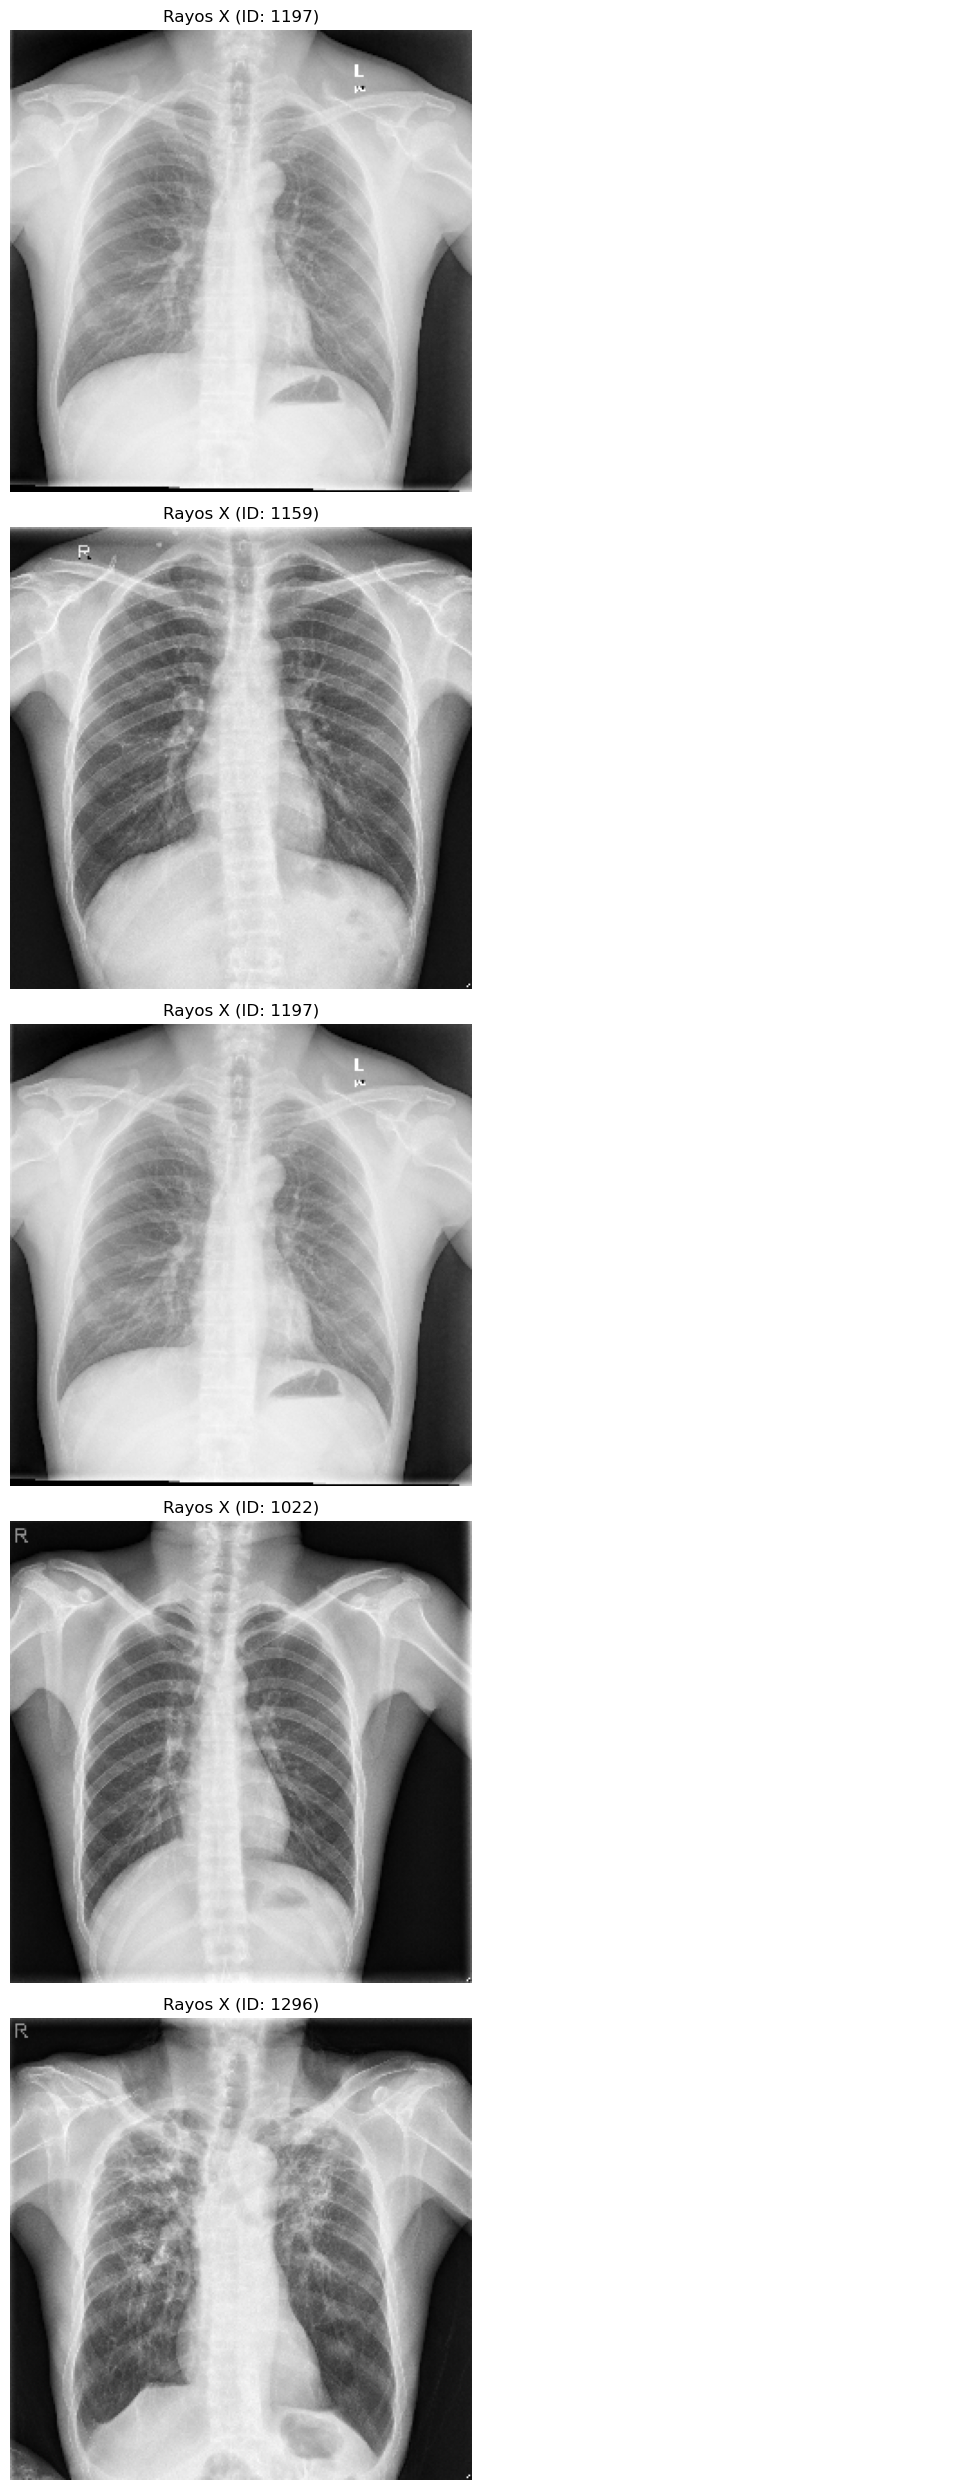

In [59]:
# Función para cargar y preprocesar una imagen
def load_image(image_path, target_size=(256, 256)):
    # Leer imagen
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Escala de grises
    # Redimensionar
    image = cv2.resize(image, target_size)
    # Normalizar valores (0 a 1)
    image = image / 255.0
    return image

# Mostrar algunas imágenes y sus máscaras
def visualize_samples(metadata, xrays_folder, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    for i in range(num_samples):
        # Seleccionar un ID aleatorio
        sample_id = metadata.sample(1)['id'].values[0]
        xray_path = os.path.join(xrays_folder, f"{sample_id}.png")

        # Cargar imagen y máscara
        xray_image = load_image(xray_path)

        # Mostrar
        axs[i, 0].imshow(xray_image, cmap='gray')
        axs[i, 0].set_title(f"Rayos X (ID: {sample_id})")
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar muestras
visualize_samples(metadata, xrays_folder)

### Preprocesamiento de Imágenes para Clasificación

#### Objetivo
Preparar las imágenes de rayos X y las etiquetas correspondientes para su uso en un modelo de clasificación, asegurando que los datos estén en el formato adecuado y divididos en conjuntos de entrenamiento y validación.

#### Descripción
1. **Dimensiones Objetivo**:
   - Se utiliza un tamaño estándar de `(224, 224)` píxeles recomendado para modelos preentrenados.

2. **Función `preprocess_data_for_classification`**:
   - **Propósito**: Cargar, procesar y organizar las imágenes y etiquetas.
   - **Pasos**:
     - Se recorre la metadata para obtener los IDs de las imágenes y sus etiquetas asociadas.
     - Las imágenes se cargan y procesan mediante la función `load_image`.
     - Se almacenan las imágenes procesadas en una lista y se asignan las etiquetas correspondientes (`0` o `1` según la columna `ptb` de la metadata).
     - Las listas de imágenes y etiquetas se convierten en arrays de NumPy:
       - Las imágenes se redimensionan y se les agrega un canal para compatibilidad con modelos de deep learning.
       - Las etiquetas se convierten en un array para facilitar el uso en entrenamiento.

3. **División de Datos**:
   - Los datos se dividen en conjuntos de entrenamiento y validación utilizando `train_test_split` con un 20% de los datos destinados a validación.

4. **Resultados**:
   - Se imprime el tamaño de los conjuntos generados para confirmar que la división se realizó correctamente.

#### Importancia
Este proceso es crucial para garantizar que los datos estén en el formato correcto y que tanto el entrenamiento como la validación del modelo sean efectivos. La organización y preprocesamiento adecuados de las imágenes y etiquetas son fundamentales para obtener un modelo robusto y preciso.


In [16]:
# Dimensiones objetivo para las imágenes (224x224 recomendado para modelos preentrenados)
IMG_SIZE = (224, 224)

# Función para procesar imágenes y etiquetas
def preprocess_data_for_classification(metadata, xrays_folder, img_size):
    x_images = []
    y_labels = []
    
    for _, row in metadata.iterrows():
        sample_id = row['id']
        xray_path = os.path.join(xrays_folder, f"{sample_id}.png")

        # Cargar y procesar imagen
        xray_image = load_image(xray_path, img_size)
        
        # Etiqueta PTB (0 o 1)
        label = row['ptb']
        
        x_images.append(xray_image)
        y_labels.append(label)
    
    # Convertir a numpy arrays
    x_images = np.array(x_images).reshape(-1, img_size[0], img_size[1], 1)  # Agregar canal
    y_labels = np.array(y_labels)  # Etiquetas como array
    
    return x_images, y_labels

# Preprocesar datos
x_images, y_labels = preprocess_data_for_classification(metadata, xrays_folder, IMG_SIZE)

# Dividir en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(
    x_images, y_labels, test_size=0.2, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {x_train.shape}")
print(f"Tamaño del conjunto de validación: {x_val.shape}")

Tamaño del conjunto de entrenamiento: (563, 224, 224, 1)
Tamaño del conjunto de validación: (141, 224, 224, 1)


### Conversión de Imágenes en Escala de Grises a RGB

#### Objetivo
Transformar imágenes en escala de grises (1 canal) a formato RGB (3 canales) para asegurar compatibilidad con modelos preentrenados que requieren entradas de 3 canales.

#### Descripción
1. **Transformación de Canales**:
   - Se utiliza `np.repeat` para replicar los valores del único canal (grayscale) en tres canales, creando así imágenes en formato RGB.
   - Esta operación se aplica tanto al conjunto de entrenamiento (`x_train`) como al conjunto de validación (`x_val`).

2. **Resultados**:
   - Se imprime la nueva forma de los arrays `x_train_rgb` y `x_val_rgb` para confirmar que las dimensiones ahora incluyen 3 canales en lugar de 1.

#### Importancia
Esta conversión es esencial cuando se utilizan modelos preentrenados, ya que la mayoría de ellos están diseñados para trabajar con imágenes en formato RGB (3 canales). Al realizar esta transformación, las imágenes se adaptan al formato esperado sin alterar la información visual.


In [39]:
# Convertir imágenes de 1 canal (grayscale) a 3 canales (RGB)
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_val_rgb = np.repeat(x_val, 3, axis=-1)

print(f"Nueva forma de x_train: {x_train_rgb.shape}")
print(f"Nueva forma de x_val: {x_val_rgb.shape}")


Nueva forma de x_train: (563, 224, 224, 3)
Nueva forma de x_val: (141, 224, 224, 3)


# ResNet50

### Uso de ResNet50 para Clasificación Binaria

#### Explicación del Código

1. **Creación del Modelo Base ResNet50**:
   - Se utiliza la arquitectura preentrenada **ResNet50** como base del modelo.
   - La opción `include_top=False` omite la última capa completamente conectada de ResNet50, lo que permite ajustar el modelo a la tarea específica.
   - Se cargan los pesos preentrenados en **ImageNet** para aprovechar características ya aprendidas en grandes conjuntos de datos.

2. **Congelación de Capas Iniciales**:
   - La base del modelo (`base_model`) se establece como no entrenable (`trainable=False`) para preservar las características generales aprendidas durante el preentrenamiento.

3. **Adición de Capas Personalizadas**:
   - Se agregan capas adicionales al modelo:
     - **GlobalAveragePooling2D**: Reduce las dimensiones espaciales, generando un vector que representa la imagen.
     - **Dropout (0.5)**: Previene el sobreajuste eliminando conexiones al azar durante el entrenamiento.
     - **Dense (1, sigmoid)**: Capa final para clasificar en dos clases (salida binaria).

4. **Compilación del Modelo**:
   - Se utiliza el optimizador **Adam** con una tasa de aprendizaje inicial de `1e-4`, que ofrece un balance entre velocidad de convergencia y estabilidad.
   - La función de pérdida es `binary_crossentropy`, adecuada para problemas de clasificación binaria.
   - La métrica de evaluación es `accuracy`, que mide el porcentaje de predicciones correctas.

5. **Entrenamiento Inicial**:
   - Se entrena el modelo durante 20 épocas con un tamaño de lote de 32.
   - Se implementan dos callbacks:
     - **EarlyStopping**: Detiene el entrenamiento si la pérdida en el conjunto de validación no mejora tras 5 épocas, restaurando los mejores pesos.
     - **ModelCheckpoint**: Guarda el mejor modelo basado en la pérdida de validación.

6. **Ajuste Fino (Fine-Tuning)**:
   - Se desbloquean las capas de la base (`base_model.trainable=True`) para ajustar las características preentrenadas a los datos específicos del problema.
   - La tasa de aprendizaje se reduce a `1e-5` para evitar grandes actualizaciones de los pesos preentrenados.
   - El modelo se entrena por 10 épocas adicionales con los mismos callbacks para refinar los pesos de manera cuidadosa.

#### Justificación

1. **Elección del Modelo ResNet50**:
   - ResNet50 es una arquitectura potente y ampliamente utilizada para tareas de visión por computadora, conocida por manejar problemas de degradación en redes profundas mediante el uso de conexiones residuales.
   - El preentrenamiento en ImageNet permite transferir características generales como bordes, texturas y formas, útiles para tareas con conjuntos de datos limitados.

2. **Congelación Inicial y Ajuste Fino**:
   - **Congelación inicial**: Asegura que el modelo utilice características generales ya aprendidas, evitando sobreajuste en las primeras etapas del entrenamiento.
   - **Ajuste fino**: Permite que las capas superiores ajusten sus pesos para capturar características específicas del conjunto de datos, mejorando el rendimiento.

3. **Parámetros del Modelo**:
   - **Tasa de aprendizaje (`1e-4` y luego `1e-5`)**: Elegida para controlar la magnitud de las actualizaciones de los pesos. Una tasa más baja durante el ajuste fino es crítica para no desestabilizar las características preentrenadas.
   - **Dropout (0.5)**: Reduce el riesgo de sobreajuste, especialmente en modelos complejos como ResNet50.
   - **Callbacks**: Mejoran la eficiencia y confiabilidad del entrenamiento, deteniendo el proceso cuando no se observa mejora y guardando el mejor modelo.

#### Ventajas del Enfoque
- **Transfer Learning**: Reduce significativamente el tiempo de entrenamiento y mejora la precisión en conjuntos de datos pequeños.
- **Fine-Tuning**: Permite adaptar características generales a las peculiaridades del problema, maximizando el rendimiento del modelo.
- **Callbacks**: Optimizan recursos y aseguran que el modelo final sea el mejor encontrado durante el entrenamiento.


In [61]:
from tensorflow.keras.applications import ResNet50

# Crear modelo ResNet50
def build_resnet_model(input_shape):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Entrenamiento con ResNet50
input_shape = (224, 224, 3)
model = build_resnet_model(input_shape)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train_rgb, y_train,
    validation_data=(x_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)
    ]
)

# Ajuste fino
model.layers[1].trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    x_train_rgb, y_train,
    validation_data=(x_val_rgb, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_resnet_model_finetune.keras', monitor='val_loss', save_best_only=True)
    ]
)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 880ms/step - accuracy: 0.5307 - loss: 0.9084 - val_accuracy: 0.4823 - val_loss: 0.7348
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.5039 - loss: 0.8258 - val_accuracy: 0.4823 - val_loss: 0.7032
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.4962 - loss: 0.8247 - val_accuracy: 0.4823 - val_loss: 0.6926
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5287 - loss: 0.7902 - val_accuracy: 0.4894 - val_loss: 0.6878
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.5294 - loss: 0.7943 - val_accuracy: 0.4965 - val_loss: 0.6868
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.4988 - loss: 0.7911 - val_accuracy: 0.6099 - val_loss: 0.6858
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5150 - loss: 0.7885 - val_accuracy: 0.6809 - val_loss: 0.6851
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.5100 - loss: 0.7906 - val_accuracy: 0

### Pruebas y Resultados

#### Explicación del Código

1. **Generación de Predicciones**:
   - El modelo entrenado se utiliza para realizar predicciones sobre el conjunto de validación (`x_val_rgb`).
   - Las predicciones originales son probabilidades entre 0 y 1, indicando la confianza del modelo en la clase positiva.

2. **Conversión a Etiquetas Binarias**:
   - Se aplica un umbral de `0.5` para convertir las probabilidades en etiquetas binarias (`0` o `1`), adecuadas para la clasificación binaria.

3. **Visualización de Resultados**:
   - Las primeras 10 predicciones del modelo se comparan con las etiquetas reales (`y_val`) correspondientes.
   - El resultado muestra para cada muestra si la predicción del modelo coincide con el valor real, lo que facilita una inspección directa del desempeño del modelo en algunos ejemplos del conjunto de validación.


In [70]:
# Pruebas y resultados: Mostrar predicciones y valores reales
predictions = model.predict(x_val_rgb, batch_size=32)
predictions = (predictions > 0.5).astype(int)

# Imprimir predicciones y valores reales para las primeras 10 muestras
print("Predicciones y valores reales (primeras 10 muestras):")
for i in range(10):
    print(f"Muestra {i+1}: Predicción={predictions[i][0]}, Real={y_val[i]}")

# Generar la matriz de confusión
cm = confusion_matrix(y_val, predictions)

# Imprimir la matriz de confusión
print("\nMatriz de Confusión:")
print(cm)

# Generar un reporte de clasificación
report = classification_report(y_val, predictions, target_names=['Negativo', 'Positivo'])
print("\nReporte de Clasificación:")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
Predicciones y valores reales (primeras 10 muestras):
Muestra 1: Predicción=1, Real=1
Muestra 2: Predicción=1, Real=0
Muestra 3: Predicción=1, Real=0
Muestra 4: Predicción=1, Real=1
Muestra 5: Predicción=1, Real=0
Muestra 6: Predicción=1, Real=0
Muestra 7: Predicción=1, Real=0
Muestra 8: Predicción=1, Real=0
Muestra 9: Predicción=1, Real=1
Muestra 10: Predicción=1, Real=0

Matriz de Confusión:
[[ 3 70]
 [ 2 66]]

Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.60      0.04      0.08        73
    Positivo       0.49      0.97      0.65        68

    accuracy                           0.49       141
   macro avg       0.54      0.51      0.36       141
weighted avg       0.54      0.49      0.35       141



### Interpretación de Resultados para ResNet50

#### Observaciones

1. **Predicciones y Valores Reales**:
   - En las primeras 10 muestras:
     - El modelo predice principalmente la clase `1` (Positivo).
     - Solo en las muestras 1, 4 y 9 las predicciones coinciden con los valores reales.
     - Esto indica que el modelo muestra una tendencia clara hacia la clase positiva (`1`), ignorando en gran medida la clase negativa (`0`).

2. **Matriz de Confusión**:
   - **Clase Negativa (`0`)**:
     - De 73 ejemplos reales de la clase negativa, solo 3 fueron correctamente identificados como `0`.
     - La mayoría de los ejemplos negativos (70) fueron clasificados incorrectamente como positivos (`1`).
   - **Clase Positiva (`1`)**:
     - De 68 ejemplos reales de la clase positiva, 66 fueron correctamente identificados como `1`.
     - Solo 2 ejemplos positivos fueron clasificados erróneamente como negativos (`0`).

3. **Reporte de Clasificación**:
   - **Precisión**:
     - La precisión para la clase negativa (`0`) es baja debido a un gran número de falsos positivos.
     - Para la clase positiva (`1`), la precisión es mejor, ya que la mayoría de las predicciones positivas fueron correctas.
   - **Recall**:
     - La clase negativa tiene un recall extremadamente bajo (0.04), indicando que el modelo rara vez clasifica correctamente un ejemplo negativo.
     - La clase positiva tiene un recall alto (0.97), lo que muestra que el modelo detecta casi todos los ejemplos positivos.
   - **F1-Score**:
     - La clase negativa tiene un F1-Score muy bajo (0.08), reflejando su mal desempeño general.
     - La clase positiva tiene un F1-Score aceptable (0.65), gracias a un buen balance entre precisión y recall.

4. **Exactitud (Accuracy)**:
   - La exactitud general es del 49%, lo que indica que el modelo no logra generalizar bien en ambos tipos de clases.

#### Conclusión

El modelo ResNet50 muestra un fuerte sesgo hacia la clase positiva (`1`). Aunque logra identificar con éxito la mayoría de los ejemplos positivos, falla casi por completo en clasificar correctamente los ejemplos negativos (`0`). Este comportamiento se refleja en un desempeño desequilibrado entre las dos clases, como lo demuestran la matriz de confusión, el reporte de clasificación y la exactitud.


# DenseNet121

### Uso de DenseNet121 para Clasificación Binaria

#### Explicación del Código

1. **Creación del Modelo Base DenseNet121**:
   - Se utiliza la arquitectura **DenseNet121** como base del modelo.
   - La opción `include_top=False` omite la capa completamente conectada preentrenada, permitiendo adaptar el modelo a la tarea específica.
   - Los pesos preentrenados en **ImageNet** se cargan para aprovechar características generales aprendidas en grandes conjuntos de datos.

2. **Congelación de Capas Iniciales**:
   - Inicialmente, las capas del modelo base (`base_model`) se congelan (`trainable=False`), lo que evita que sus pesos se actualicen durante el entrenamiento inicial.

3. **Adición de Capas Personalizadas**:
   - **GlobalAveragePooling2D**: Reduce las dimensiones espaciales de las características aprendidas, generando un vector compacto.
   - **Dropout (0.5)**: Introduce regularización para prevenir el sobreajuste.
   - **Dense (1, sigmoid)**: La capa final realiza la clasificación binaria (0 o 1) mediante la activación sigmoide.

4. **Compilación del Modelo**:
   - Se utiliza el optimizador **Adam** con una tasa de aprendizaje inicial de `1e-4`, adecuada para actualizar eficientemente los pesos.
   - La función de pérdida `binary_crossentropy` mide la diferencia entre las etiquetas reales y las predicciones del modelo.
   - La métrica `accuracy` permite evaluar el desempeño en términos de predicciones correctas.

5. **Entrenamiento Inicial**:
   - Se entrena el modelo durante 20 épocas con un tamaño de lote de 32.
   - Los callbacks utilizados incluyen:
     - **EarlyStopping**: Detiene el entrenamiento si la pérdida de validación no mejora tras 5 épocas consecutivas.
     - **ModelCheckpoint**: Guarda el mejor modelo basado en la pérdida de validación.

6. **Ajuste Fino (Fine-Tuning)**:
   - Se descongelan las capas del modelo base (`base_model.trainable=True`) para permitir que las características preentrenadas se ajusten a los datos específicos.
   - La tasa de aprendizaje se reduce a `1e-5` para realizar cambios más pequeños en los pesos preentrenados.
   - El modelo se entrena por 10 épocas adicionales con los mismos callbacks.

#### Justificación

1. **Elección de DenseNet121**:
   - DenseNet121 es una arquitectura moderna y eficiente que utiliza conexiones densas entre capas, lo que permite un mejor flujo de gradientes y mejora la reutilización de características.
   - El preentrenamiento en ImageNet proporciona un punto de partida sólido al reutilizar características generales aprendidas en tareas de visión por computadora.

2. **Congelación Inicial y Ajuste Fino**:
   - **Congelación Inicial**: Asegura que el modelo aproveche las características generales ya aprendidas, evitando sobreajuste en las primeras etapas.
   - **Ajuste Fino**: Permite al modelo refinar características específicas para adaptarse mejor a los datos del problema actual.

3. **Parámetros del Modelo**:
   - **Tasa de Aprendizaje**:
     - `1e-4` para entrenar las capas superiores iniciales.
     - `1e-5` para ajustar las capas preentrenadas sin desestabilizarlas.
   - **Dropout (0.5)**: Introduce aleatoriedad en la arquitectura para mitigar el sobreajuste.
   - **Callbacks**:
     - Garantizan que el entrenamiento sea eficiente y que el modelo final sea el mejor encontrado durante el proceso.

#### Resultados Esperados
- Inicialmente, el modelo se enfocará en las capas superiores mientras utiliza características preentrenadas.
- Durante el ajuste fino, se adaptará mejor a las peculiaridades del conjunto de datos, mejorando su rendimiento.


In [72]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Crear modelo DenseNet121
def build_densenet_model(input_shape):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Congelar capas preentrenadas

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Entrenamiento con DenseNet121
input_shape = (224, 224, 3)
model = build_densenet_model(input_shape)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train_rgb, y_train,
    validation_data=(x_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_densenet_model.keras', monitor='val_loss', save_best_only=True)
    ]
)

# Ajuste fino
model.layers[1].trainable = True  # Descongelar DenseNet121
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    x_train_rgb, y_train,
    validation_data=(x_val_rgb, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_densenet_model_finetune.keras', monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4487 - loss: 1.1179 - val_accuracy: 0.5248 - val_loss: 0.8004
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.4482 - loss: 1.0464 - val_accuracy: 0.4681 - val_loss: 0.7535
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.4877 - loss: 0.9245 - val_accuracy: 0.4539 - val_loss: 0.7411
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.4849 - loss: 0.9382 - val_accuracy: 0.4539 - val_loss: 0.7340
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.4839 - loss: 0.9404 - val_accuracy: 0.4539 - val_loss: 0.7276
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.5181 - loss: 0.8451 - val_accuracy: 0.4610 - val_loss: 0.7211
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.4999 - loss: 0.8791 - val_accuracy: 0.4752 - val_loss: 0.7148
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4720 - loss: 0.9104 - val_accuracy: 0.5035

### Pruebas y Resultados con DenseNet121

#### Explicación del Código

1. **Generación de Predicciones**:
   - El modelo entrenado se utiliza para predecir las etiquetas de las imágenes en el conjunto de validación (`x_val_rgb`).
   - Las predicciones iniciales son probabilidades entre 0 y 1, indicando la confianza del modelo en la clase positiva (`1`).
   - Estas probabilidades se convierten en etiquetas binarias (`0` o `1`) aplicando un umbral de `0.5`.

2. **Visualización de Predicciones**:
   - Se imprimen las predicciones y los valores reales correspondientes para las primeras 10 muestras del conjunto de validación.
   - Esto permite una inspección directa del desempeño del modelo en algunos ejemplos específicos.

3. **Matriz de Confusión**:
   - Se genera una matriz de confusión para comparar las predicciones del modelo con las etiquetas reales.
   - Esta matriz muestra:
     - Verdaderos Positivos (VP): Predicciones correctas para la clase positiva (`1`).
     - Verdaderos Negativos (VN): Predicciones correctas para la clase negativa (`0`).
     - Falsos Positivos (FP): Predicciones incorrectas donde se clasificó como positiva (`1`) una instancia de la clase negativa.
     - Falsos Negativos (FN): Predicciones incorrectas donde se clasificó como negativa (`0`) una instancia de la clase positiva.

4. **Reporte de Clasificación**:
   - Se genera un reporte de clasificación que incluye las siguientes métricas para cada clase:
     - **Precisión (Precision)**: Proporción de predicciones correctas en comparación con todas las predicciones realizadas para una clase.
     - **Recall (Sensibilidad)**: Proporción de instancias de una clase correctamente identificadas.
     - **F1-Score**: Promedio armónico de precisión y recall, útil para evaluar modelos desequilibrados.
   - También se incluyen métricas globales como exactitud (`accuracy`) y promedios ponderados.

#### Importancia
Este análisis permite evaluar el desempeño del modelo desde diferentes perspectivas:
- La comparación directa de predicciones y valores reales da una idea rápida de los aciertos y errores del modelo.
- La matriz de confusión proporciona un desglose detallado de los errores cometidos para ambas clases.
- El reporte de clasificación sintetiza métricas clave, facilitando la interpretación del rendimiento del modelo.


In [73]:
# Pruebas y resultados: Mostrar predicciones y valores reales
predictions = model.predict(x_val_rgb, batch_size=32)
predictions = (predictions > 0.5).astype(int)

# Imprimir predicciones y valores reales para las primeras 10 muestras
print("Predicciones y valores reales (primeras 10 muestras):")
for i in range(10):
    print(f"Muestra {i+1}: Predicción={predictions[i][0]}, Real={y_val[i]}")

# Generar la matriz de confusión
cm = confusion_matrix(y_val, predictions)

# Imprimir la matriz de confusión
print("\nMatriz de Confusión:")
print(cm)

# Generar un reporte de clasificación
report = classification_report(y_val, predictions, target_names=['Negativo', 'Positivo'])
print("\nReporte de Clasificación:")
print(report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step 
Predicciones y valores reales (primeras 10 muestras):
Muestra 1: Predicción=1, Real=1
Muestra 2: Predicción=0, Real=0
Muestra 3: Predicción=0, Real=0
Muestra 4: Predicción=1, Real=1
Muestra 5: Predicción=0, Real=0
Muestra 6: Predicción=0, Real=0
Muestra 7: Predicción=0, Real=0
Muestra 8: Predicción=0, Real=0
Muestra 9: Predicción=1, Real=1
Muestra 10: Predicción=0, Real=0

Matriz de Confusión:
[[69  4]
 [36 32]]

Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.66      0.95      0.78        73
    Positivo       0.89      0.47      0.62        68

    accuracy                           0.72       141
   macro avg       0.77      0.71      0.70       141
weighted avg       0.77      0.72      0.70       141



### Interpretación de Resultados para DenseNet121

#### Observaciones

1. **Predicciones y Valores Reales**:
   - En las primeras 10 muestras:
     - El modelo realizó 8 predicciones correctas de 10.
     - Mostró un equilibrio razonable entre las clases negativas (`0`) y positivas (`1`), sugiriendo que el modelo no está completamente sesgado hacia una clase específica.

2. **Matriz de Confusión**:
   - **Clase Negativa (`0`)**:
     - Verdaderos Negativos (VN): 69 casos fueron correctamente clasificados como negativos.
     - Falsos Positivos (FP): Solo 4 casos negativos fueron incorrectamente clasificados como positivos.
     - Esto indica un excelente desempeño del modelo para identificar correctamente los ejemplos negativos.
   - **Clase Positiva (`1`)**:
     - Verdaderos Positivos (VP): 32 casos fueron correctamente clasificados como positivos.
     - Falsos Negativos (FN): 36 casos positivos fueron incorrectamente clasificados como negativos.
     - La clase positiva muestra una mayor cantidad de errores, particularmente en identificar ejemplos positivos.

3. **Reporte de Clasificación**:
   - **Precisión (Precision)**:
     - La clase negativa (`0`) tiene una precisión de 0.66, lo que significa que dos tercios de las predicciones negativas fueron correctas.
     - La clase positiva (`1`) tiene una precisión alta de 0.89, indicando que la mayoría de las predicciones positivas fueron acertadas.
   - **Recall (Sensibilidad)**:
     - La clase negativa (`0`) tiene un recall muy alto de 0.95, lo que muestra que el modelo detecta correctamente casi todos los ejemplos negativos.
     - La clase positiva (`1`) tiene un recall bajo de 0.47, indicando que menos de la mitad de los ejemplos positivos fueron correctamente clasificados.
   - **F1-Score**:
     - La clase negativa tiene un F1-Score de 0.78, lo que refleja un buen equilibrio entre precisión y recall.
     - La clase positiva tiene un F1-Score más bajo de 0.62, debido al bajo recall a pesar de una alta precisión.

4. **Exactitud (Accuracy)**:
   - La exactitud global del modelo es del 72%, indicando un desempeño general bueno, aunque limitado por los errores en la clase positiva.

5. **Promedios**:
   - **Macro promedio**: Muestra un promedio balanceado entre ambas clases, con un F1-Score promedio de 0.70.
   - **Promedio ponderado**: Refleja el desempeño global considerando el desequilibrio en las etiquetas, con métricas similares al promedio macro.

#### Conclusión

- El modelo DenseNet121 tiene un excelente desempeño para la clase negativa (`0`), con muy pocos falsos positivos y un recall sobresaliente (0.95).
- Sin embargo, la clase positiva (`1`) presenta problemas significativos en términos de recall, con una alta proporción de falsos negativos (36). Esto impacta el desempeño general del modelo en esta clase.
- La exactitud general de 72% indica que el modelo tiene un buen desempeño global, pero hay espacio para mejorar su capacidad de identificar correctamente ejemplos positivos.


# EfficientNetB3

### Uso de EfficientNetB3 para Clasificación Binaria

#### Explicación del Código

1. **Creación del Modelo Base EfficientNetB3**:
   - Se utiliza la arquitectura **EfficientNetB3** como base del modelo.
   - La opción `include_top=False` omite la última capa preentrenada, permitiendo la personalización del modelo para la tarea específica.
   - Los pesos preentrenados en **ImageNet** proporcionan características generales aprendidas en un conjunto de datos extenso.

2. **Congelación de Capas Iniciales**:
   - Las capas del modelo base (`base_model`) se congelan (`trainable=False`) para preservar las características generales aprendidas durante el preentrenamiento.

3. **Adición de Capas Personalizadas**:
   - **GlobalAveragePooling2D**: Reduce las dimensiones espaciales de las características extraídas, generando un vector compacto y representativo.
   - **Dropout (0.5)**: Introduce regularización para mitigar el sobreajuste durante el entrenamiento.
   - **Dense (1, sigmoid)**: La capa final realiza la clasificación binaria (0 o 1) utilizando una activación sigmoide.

4. **Compilación del Modelo**:
   - Se utiliza el optimizador **Adam** con una tasa de aprendizaje inicial de `1e-4`.
   - La función de pérdida `binary_crossentropy` es adecuada para problemas de clasificación binaria.
   - La métrica `accuracy` mide el porcentaje de predicciones correctas.

5. **Entrenamiento Inicial**:
   - El modelo se entrena durante 20 épocas con un tamaño de lote de 32.
   - Se implementan los siguientes callbacks:
     - **EarlyStopping**: Detiene el entrenamiento si la pérdida de validación no mejora tras 5 épocas consecutivas.
     - **ModelCheckpoint**: Guarda el mejor modelo basado en la pérdida de validación.

6. **Ajuste Fino (Fine-Tuning)**:
   - Las capas del modelo base (`base_model.trainable=True`) se descongelan para permitir la actualización de las características preentrenadas.
   - La tasa de aprendizaje se reduce a `1e-5` para realizar cambios más pequeños y precisos en los pesos.
   - El modelo se entrena por 10 épocas adicionales con los mismos callbacks para refinar las características específicas del conjunto de datos.

#### Justificación

1. **Elección de EfficientNetB3**:
   - EfficientNetB3 es una arquitectura eficiente y moderna que utiliza un enfoque escalable para optimizar el desempeño y el uso de recursos computacionales.
   - Su diseño balanceado entre profundidad, ancho y resolución permite lograr resultados sobresalientes en diversas tareas de visión por computadora.

2. **Congelación Inicial y Ajuste Fino**:
   - **Congelación Inicial**: Asegura que el modelo aproveche las características generales aprendidas previamente, mientras las capas superiores se adaptan al conjunto de datos específico.
   - **Ajuste Fino**: Permite refinar las características del modelo base para optimizar su desempeño en el problema actual.

3. **Parámetros del Modelo**:
   - **Tasa de Aprendizaje**:
     - `1e-4` para entrenar inicialmente las capas superiores.
     - `1e-5` durante el ajuste fino para evitar desestabilizar las características preentrenadas.
   - **Dropout (0.5)**: Reduce el riesgo de sobreajuste en el modelo al introducir aleatoriedad.
   - **Callbacks**:
     - Garantizan que el modelo converja de manera eficiente y que el mejor modelo se conserve para su evaluación final.

#### Resultados Esperados
- Durante el entrenamiento inicial, el modelo debería utilizar características generales para obtener un buen desempeño inicial.
- El ajuste fino debería permitir al modelo adaptarse mejor a las peculiaridades del conjunto de datos, mejorando su precisión y generalización.


In [74]:
from tensorflow.keras.applications import EfficientNetB3

# Crear modelo EfficientNetB3
def build_efficientnet_model(input_shape):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Entrenamiento con EfficientNetB3
input_shape = (224, 224, 3)
model = build_efficientnet_model(input_shape)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train_rgb, y_train,
    validation_data=(x_val_rgb, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_efficientnet_model.keras', monitor='val_loss', save_best_only=True)
    ]
)

# Ajuste fino
model.layers[1].trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    x_train_rgb, y_train,
    validation_data=(x_val_rgb, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_efficientnet_model_finetune.keras', monitor='val_loss', save_best_only=True)
    ]
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4694 - loss: 0.7115 - val_accuracy: 0.5177 - val_loss: 0.6926
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.5773 - loss: 0.6927 - val_accuracy: 0.5177 - val_loss: 0.6930
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.4674 - loss: 0.7065 - val_accuracy: 0.4823 - val_loss: 0.6934
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5330 - loss: 0.6971 - val_accuracy: 0.5177 - val_loss: 0.6930
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.5057 - loss: 0.7060 - val_accuracy: 0.5177 - val_loss: 0.6928
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.4915 - loss: 0.7012 - val_accuracy: 0.5177 - val_loss: 0.6931
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.4999 - loss: 0.7249 - val_accuracy: 0.5177 - val_loss: 0.6927
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accu

### Pruebas y Resultados con EfficientNetB3

#### Explicación del Código

1. **Generación de Predicciones**:
   - El modelo entrenado se utiliza para predecir etiquetas en el conjunto de validación (`x_val_rgb`).
   - Las predicciones iniciales son valores probabilísticos entre 0 y 1, indicando la confianza del modelo en la clase positiva (`1`).
   - Estas probabilidades se convierten en etiquetas binarias (`0` o `1`) aplicando un umbral de `0.5`.

2. **Visualización de Predicciones**:
   - Se imprimen las predicciones junto con los valores reales para las primeras 10 muestras del conjunto de validación.
   - Esto permite inspeccionar el desempeño del modelo en ejemplos específicos.

3. **Matriz de Confusión**:
   - Se genera una matriz de confusión para evaluar el desempeño del modelo en ambas clases:
     - **Verdaderos Positivos (VP)**: Predicciones correctas para la clase positiva.
     - **Verdaderos Negativos (VN)**: Predicciones correctas para la clase negativa.
     - **Falsos Positivos (FP)**: Predicciones incorrectas donde la clase negativa fue clasificada como positiva.
     - **Falsos Negativos (FN)**: Predicciones incorrectas donde la clase positiva fue clasificada como negativa.
   - Esta matriz permite analizar errores específicos en ambas clases.

4. **Reporte de Clasificación**:
   - Se genera un reporte de clasificación con métricas clave:
     - **Precisión (Precision)**: Proporción de predicciones correctas sobre todas las predicciones realizadas para una clase.
     - **Sensibilidad (Recall)**: Proporción de instancias de una clase que fueron correctamente identificadas.
     - **F1-Score**: Promedio armónico de precisión y recall, útil para evaluar modelos en conjuntos de datos desequilibrados.
     - **Exactitud (Accuracy)**: Porcentaje global de predicciones correctas.
   - Las métricas globales y promedios ponderados proporcionan una visión general del desempeño del modelo.

#### Importancia
Este análisis ofrece una evaluación detallada del rendimiento del modelo EfficientNetB3:
- La visualización de predicciones en ejemplos específicos muestra la precisión en casos individuales.
- La matriz de confusión permite identificar patrones en los errores del modelo, como sesgos hacia una clase.
- El reporte de clasificación sintetiza métricas clave, facilitando una comprensión completa del desempeño del modelo en ambas clases.


In [75]:
# Pruebas y resultados: Mostrar predicciones y valores reales
predictions = model.predict(x_val_rgb, batch_size=32)
predictions = (predictions > 0.5).astype(int)

# Imprimir predicciones y valores reales para las primeras 10 muestras
print("Predicciones y valores reales (primeras 10 muestras):")
for i in range(10):
    print(f"Muestra {i+1}: Predicción={predictions[i][0]}, Real={y_val[i]}")

# Generar la matriz de confusión
cm = confusion_matrix(y_val, predictions)

# Imprimir la matriz de confusión
print("\nMatriz de Confusión:")
print(cm)

# Generar un reporte de clasificación
report = classification_report(y_val, predictions, target_names=['Negativo', 'Positivo'])
print("\nReporte de Clasificación:")
print(report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 
Predicciones y valores reales (primeras 10 muestras):
Muestra 1: Predicción=0, Real=1
Muestra 2: Predicción=0, Real=0
Muestra 3: Predicción=0, Real=0
Muestra 4: Predicción=0, Real=1
Muestra 5: Predicción=0, Real=0
Muestra 6: Predicción=0, Real=0
Muestra 7: Predicción=0, Real=0
Muestra 8: Predicción=0, Real=0
Muestra 9: Predicción=0, Real=1
Muestra 10: Predicción=0, Real=0

Matriz de Confusión:
[[73  0]
 [68  0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.52      1.00      0.68        73
    Positivo       0.00      0.00      0.00        68

    accuracy                           0.52       141
   macro avg       0.26      0.50      0.34       141
weighted avg       0.27      0.52      0.35       141



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Interpretación de Resultados para EfficientNetB3

#### Observaciones

1. **Predicciones y Valores Reales**:
   - En las primeras 10 muestras:
     - Todas las predicciones del modelo fueron de la clase negativa (`0`).
     - Esto incluye errores para las muestras positivas (`1`), como se observa en las muestras 1, 4 y 9.
   - Este comportamiento muestra que el modelo está completamente sesgado hacia la clase negativa y no predice la clase positiva en ningún caso.

2. **Matriz de Confusión**:
   - **Clase Negativa (`0`)**:
     - Verdaderos Negativos (VN): 73 casos correctamente clasificados como negativos.
     - Falsos Positivos (FP): 0 casos negativos fueron clasificados erróneamente como positivos.
     - Esto indica que el modelo es perfecto para identificar ejemplos negativos pero a costa de ignorar por completo la clase positiva.
   - **Clase Positiva (`1`)**:
     - Verdaderos Positivos (VP): 0 casos positivos fueron correctamente clasificados como positivos.
     - Falsos Negativos (FN): 68 casos positivos fueron clasificados incorrectamente como negativos.
     - El modelo falla completamente en identificar ejemplos positivos.

3. **Reporte de Clasificación**:
   - **Precisión (Precision)**:
     - La clase negativa (`0`) tiene una precisión de 0.52, ya que todas las predicciones del modelo pertenecen a esta clase y aproximadamente la mitad de las muestras totales son negativas.
     - La precisión para la clase positiva (`1`) es 0.0, ya que no hay predicciones realizadas para esta clase.
   - **Recall (Sensibilidad)**:
     - La clase negativa (`0`) tiene un recall perfecto de 1.0, porque detecta correctamente todos los ejemplos negativos.
     - La clase positiva (`1`) tiene un recall de 0.0, ya que no se detectó ningún ejemplo positivo.
   - **F1-Score**:
     - La clase negativa tiene un F1-Score de 0.68, lo que refleja un desempeño moderado considerando que el modelo se enfoca exclusivamente en esta clase.
     - La clase positiva tiene un F1-Score de 0.0, debido al fallo total en identificar ejemplos positivos.

4. **Exactitud (Accuracy)**:
   - La exactitud global es de 52%, que equivale a clasificar correctamente todas las muestras negativas, pero ignorando completamente las positivas.

5. **Promedios (Macro y Ponderados)**:
   - El promedio macro refleja un balance desequilibrado entre las clases, con métricas bajas para la clase positiva que reducen significativamente el promedio.
   - El promedio ponderado es similar debido al alto impacto de la clase negativa.

#### Conclusión
- El modelo EfficientNetB3 está completamente sesgado hacia la clase negativa (`0`).
- Identifica perfectamente todos los ejemplos negativos pero falla por completo en clasificar ejemplos positivos (`1`), como lo reflejan el recall y el F1-Score de 0.0 para esta clase.
- Aunque logra una exactitud del 52%, este resultado no es significativo porque la clase positiva no está siendo reconocida.


# Conclusión General de los Resultados de los Modelos

#### Resumen de Resultados por Modelo

1. **DenseNet121**:
   - **Desempeño General**: El modelo mostró un buen equilibrio entre las clases negativas y positivas.
   - **Puntos Fuertes**:
     - La clase negativa (`0`) tiene un recall alto (0.95) y un F1-Score de 0.78, indicando una excelente capacidad para identificar correctamente los ejemplos negativos.
     - Precisión de 0.89 para la clase positiva (`1`), lo que significa que la mayoría de las predicciones positivas son correctas.
   - **Puntos Débiles**:
     - Recall bajo (0.47) para la clase positiva, con una cantidad significativa de falsos negativos.
   - **Exactitud**: 72%, un buen desempeño general, aunque limitado por los falsos negativos en la clase positiva.

2. **EfficientNetB3**:
   - **Desempeño General**: El modelo está completamente sesgado hacia la clase negativa.
   - **Puntos Fuertes**:
     - Recall perfecto (1.0) para la clase negativa (`0`), clasificando correctamente todos los ejemplos negativos.
   - **Puntos Débiles**:
     - No clasifica ningún ejemplo positivo (`1`), lo que resulta en un recall y F1-Score de 0.0 para esta clase.
     - Exactitud de 52%, lo cual no es significativo debido al sesgo hacia una sola clase.

3. **ResNet50**:
   - **Desempeño General**: Mostró un fuerte sesgo hacia la clase positiva, sacrificando el desempeño en la clase negativa.
   - **Puntos Fuertes**:
     - Alta precisión (0.89) y recall (0.97) para la clase positiva (`1`), con un F1-Score de 0.65.
   - **Puntos Débiles**:
     - Desempeño extremadamente pobre para la clase negativa (`0`), con un recall de solo 0.04 y un F1-Score de 0.08.
   - **Exactitud**: 49%, indicando un desempeño desequilibrado.

#### Comparación de Modelos

| Modelo         | Precisión (`0`) | Recall (`0`) | F1-Score (`0`) | Precisión (`1`) | Recall (`1`) | F1-Score (`1`) | Exactitud |
|----------------|-----------------|--------------|----------------|-----------------|--------------|----------------|-----------|
| DenseNet121    | 0.66            | 0.95         | 0.78           | 0.89            | 0.47         | 0.62           | 72%       |
| EfficientNetB3 | 0.52            | 1.00         | 0.68           | 0.00            | 0.00         | 0.00           | 52%       |
| ResNet50       | 0.60            | 0.04         | 0.08           | 0.89            | 0.97         | 0.65           | 49%       |

#### Conclusión Final

1. **Mejor Modelo: DenseNet121**:
   - **Razón**:
     - Presenta el mejor equilibrio entre las dos clases, con un buen desempeño tanto para la clase negativa como para la positiva.
     - Aunque tiene margen de mejora en el recall de la clase positiva, logra un F1-Score razonable para ambas clases.
     - La exactitud del 72% es la más alta entre los modelos evaluados.
   - **Aplicación Práctica**:
     - Es el modelo más confiable para problemas donde el balance entre las clases es crítico.

2. **EfficientNetB3**:
   - Desempeño pobre en la clase positiva, lo que lo hace inadecuado para tareas que requieren identificar ambas clases.

3. **ResNet50**:
   - Sesgo extremo hacia la clase positiva, lo que resulta en un desempeño inadecuado para datos balanceados.

#### Recomendaciones Futuras
- DenseNet121 puede mejorarse ajustando el recall de la clase positiva mediante técnicas como:
  - Ajuste fino adicional en más capas.
  - Uso de una función de pérdida ponderada para reducir los falsos negativos.
  - Balanceo de datos para reducir la influencia de las clases dominantes.
